# Proyecto Final - Analisis y procesamiento de señales - Luis Candela

## Analisis de señales de vibración de rodamientos lineales con fallas generadas

En este documento se analizará la base de datos titulada:

**_Vibration Data for Axial Ball Bearings and Spall Faults_**

Este conjunto de datos consiste en mediciones de vibración realizadas sobre rodamientos axiales, a los cuales se les indujeron fallas artificiales en las pistas internas o externas. Las fallas consisten en defectos de tipo *spall* (desprendimientos) de diferentes tamaños, generados de forma controlada para estudiar su efecto en la respuesta vibratoria del sistema.

#### Descripción del dataset original

Según la descripción proporcionada por los autores del conjunto de datos:

> Los conjuntos de datos comprenden mediciones de vibración en rodamientos axiales en condiciones tanto saludables como defectuosas. Las condiciones defectuosas se corresponden con fallas artificiales generadas en las pistas interna y externa.  
> 
> El conjunto total está compuesto por 28 archivos, divididos en dos grupos:
>
> - **Grupo 1:** 4 archivos correspondientes a rodamientos sin fallas.  
> - **Grupo 2:** 24 archivos correspondientes a 6 niveles de tamaño de falla combinados con 4 niveles de carga axial aplicada.  
> 
> Cada archivo está en formato MATLAB (`.mat`) y sigue la siguiente convención de nombres:
>  
> **NX_R_S_T.mat**, donde:
>
> - **X**: carga axial aplicada (en kN)  
> - **R**: velocidad del husillo (en rpm)  
> - **S**: ancho del defecto (*spall*) en mm  
> - **T**: ubicación de la falla (pista *interna* o *externa*)  
>
> Cada archivo contiene una única serie temporal correspondiente a la señal de vibración medida por un acelerómetro montado en la pista externa del rodamiento (en el eje radial). La carga y la velocidad permanecen constantes durante cada medición.  
> La frecuencia de muestreo es de **25.6 kHz** y cada señal tiene una duración de **30 segundos**.

Con base en esta información, el análisis buscará identificar y caracterizar las señales de vibración en función de la condición del rodamiento, el tipo y tamaño de falla, así como la carga aplicada. Para ello, se utilizará tanto el nombre de los archivos como el contenido de las señales para organizar y estructurar el análisis de forma eficiente y reproducible.


---
---

# Objetivo del análisis

Desarrollar un **procedimiento robusto de detección y caracterización** de los **transitorios impulsivos** producidos por daño (spall) en guías/rodamientos, a partir de señales de vibración muestreadas a 25.6 kHz.  
El foco principal es **identificar con precisión el inicio y fin** de cada evento de impacto y **medir su firma** (frecuencia dominante, ancho, energía y decaimiento), para apoyar el **diagnóstico temprano** y el **mantenimiento predictivo**.

> Nota: se usará **matched filtering** solo como **línea base/comparación**; el pipeline propuesto se centra en **TKEO + análisis tiempo–frecuencia (CWT)**.

---

## Objetivos particulares

1. **Pre-procesamiento adaptativo**
   - Estimar la **PSD** por señal y definir una **banda pasabanda** efectiva (≈95 % de potencia) para realzar el *ringing* de los impactos.
   - Aplicar un **filtro IIR** (Chebyshev II) y verificarlo contra su **plantilla**.

2. **Detección de eventos (inicio → fin)**
   - Calcular la **energía instantánea** con **TKEO** sobre la señal filtrada.
   - Normalizar con **z-score robusto** (mediana/MAD) y segmentar con **histéresis** (umbral alto/bajo).
   - Post-procesar: **duración mínima**, **fusión por gaps** y **dilatación** de bordes para capturar el transitorio completo.

3. **Plantilla promedio del evento**
   - Extraer cada evento detectado, **quitar DC**, unificar polaridad y **re-muestrear** a una duración común.
   - Promediar (mediana) la **forma unitaria** y **re-escalar una sola vez** por la amplitud típica → **plantilla en escala real**.

4. **Validación (opcional) por matched filter**
   - Correlacionar la plantilla con la señal para **comparar** desempeño con TKEO (no es el método principal).

5. **Caracterización tiempo–frecuencia (CWT)**
   - Calcular la **CWT (Morlet)** en la banda de interés; mejorar contraste restando **fondo por escala** y graficar en **dB** con clip robusto.
   - Obtener **métricas por evento**:
     - **$f_0$ (Hz)**: frecuencia dominante del *ringing* y su dispersión.
     - **$BW$ (Hz)**: ancho de banda; **$Q \approx f_0/BW$**.
     - **Energía (dB)** del evento.
     - **$\tau_{-20\text{dB}}$ (ms)**: tiempo de decaimiento.
     - **Duración** y **cadencia** de eventos.

6. **Síntesis y reporte**
   - Tablas y gráficos de distribución (mediana/IQR) de las métricas.
   - Comparación entre condiciones (tamaño/ubicación del *spall*, carga/velocidad) cuando aplique.

---

## Resultados esperados

- **Detección confiable** de impactos con **delimitación temporal** precisa (inicio→fin).
- **Plantilla promedio** estable del evento (firma representativa).
- **Indicadores CWT** que cuantifican la severidad/consistencia de los impactos: $f_0$, $BW$, $Q$, energía y $\tau_{-20\text{dB}}$.
- **Base objetiva** para comparar señales y sustentar decisiones de **diagnóstico** y **mantenimiento predictivo**.

---

## Criterios de éxito (medibles)

- Alta **recuperación** de eventos (pocos falsos negativos) y **baja** tasa de falsos positivos.
- **Error temporal** de localización (pico/centro) acotado respecto de la envolvente.
- **Estabilidad** de $f_0$, $BW$, $Q$ y $\tau_{-20\text{dB}}$ entre eventos de una misma condición.
- Coherencia entre **banda de filtrado** (PSD) y **banda resonante efectiva** (CWT).

---
---

## Marco teórico: detección y filtrado

### Filtro Adaptado (Matched Filter)

El **filtro adaptado**, también conocido como *matched filter*, es una herramienta ampliamente utilizada en procesamiento de señales para la detección de patrones específicos dentro de una señal ruidosa. Su fundamento se basa en maximizar la relación señal-ruido (SNR) en el punto de detección de un patrón conocido.

En términos matemáticos, el filtro adaptado realiza una **correlación cruzada** entre una señal \( x(t) \) y un patrón o plantilla \( h(t) \) (también llamado *kernel* del filtro). El resultado es una nueva señal \( y(t) \), donde los máximos indican las posiciones temporales en las que la señal original se asemeja al patrón buscado.

$
y(t) = (x \star h)(t) = \int x(\tau) \cdot h(t + \tau) \, d\tau
$

En el caso discreto:

$
y[n] = \sum_{k=0}^{N-1} x[n+k] \cdot h[k]
$

Donde:
- $ x[n] $ es la señal observada.
- $ h[k] $ es el patrón o plantilla del filtro.
- $ y[n] $ es la señal de salida del filtro adaptado.

#### Aplicación en el análisis de vibraciones

En este trabajo, se utilizará el filtro adaptado para detectar eventos característicos relacionados con fallas en rodamientos. Para ello:
- Se extraerá un **patrón de falla** a partir de una sección conocida de la señal.
- Luego, se aplicará el filtro adaptado sobre señales completas para localizar los instantes en los que dicho patrón vuelve a aparecer.

Esta técnica permite mejorar la capacidad de detección frente a ruido y es especialmente útil en entornos donde las señales son complejas y de baja SNR.

---

### Filtrado Espacial Promediado

El **filtrado espacial** hace referencia a una técnica de alineamiento y promedio de segmentos de señal que comparten una estructura común. Este método se utiliza para mejorar la estimación de un patrón repetitivo dentro de una señal contaminada con ruido.

#### Procedimiento general:

1. **Segmentación**: se seleccionan múltiples ventanas de la señal (de longitud fija \( N \)) que contengan una versión del patrón deseado.
2. **Almacenamiento**: cada segmento se almacena como una fila de una matriz de tamaño \( R \times N \), donde \( R \) es el número de ocurrencias.
3. **Promediado**: se realiza un promedio por columnas sobre la matriz para obtener una versión más limpia del patrón deseado.

$
h[k] = \frac{1}{R} \sum_{r=1}^{R} x_r[k]
$

Donde:
- $ x_r[k] $ es el \( r \)-ésimo segmento de la señal.
- $ h[k] $ es el patrón promedio utilizado posteriormente en el filtro adaptado.

#### Relación con señales biomédicas

Este procedimiento es análogo al usado para construir plantillas en señales como el **ECG**, donde se promedian múltiples ciclos cardíacos para obtener una representación clara del complejo QRS. En el contexto de este trabajo, la periodicidad o repetitividad de ciertos eventos de vibración causados por fallas permitirá construir patrones robustos para su detección automática.

---

### Síntesis

El uso combinado de:
- **Filtrado espacial promediado** para generar patrones confiables, y
- **Filtro adaptado** para detectar dichos patrones en señales ruidosas,

Va a permitir desarrollar un sistema efectivo de diagnóstico basado en vibraciones para rodamientos. Esta metodología es extensible a otros dominios donde se deseen identificar eventos transitorios o repetitivos en señales de tiempo.


---

## Vamos a comenzar cargando las señales desde los archivos originales

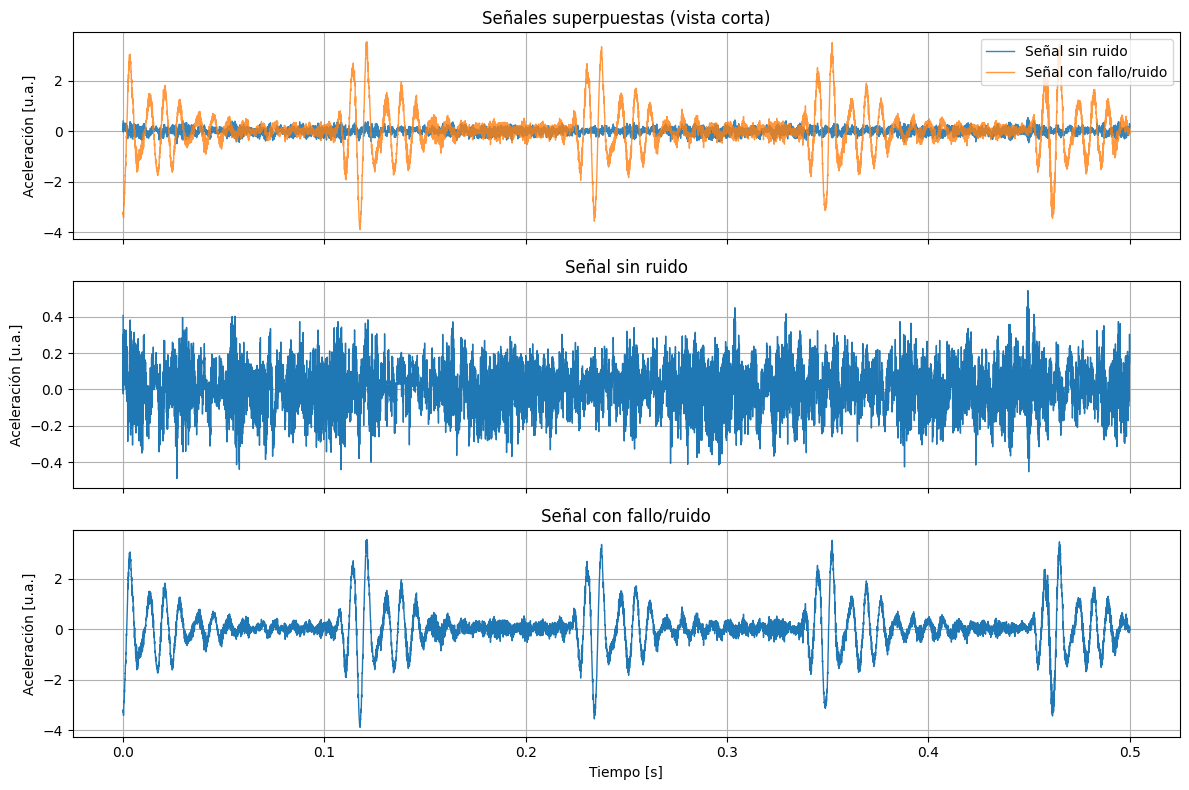

In [111]:
#%% ===========================
# 0) Configuración e imports
#=============================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import scipy.io as sio
from scipy.signal import (welch, get_window, iirdesign, sosfiltfilt,
                          hilbert, fftconvolve, correlate, sosfreqz)

# --- Ruta y archivo a analizar (ajustar según tu PC) ---
fs = 25_600  # Hz (dataset)
BASE_DIR = Path(r"/home/luis/Programacion/APS_Final")

# Señal "con ruido"
FILE_NOISY = BASE_DIR / "N5k_60_1.0_inner.mat"  # ej: con daño

# Archivo "sin ruido" 
FILE_CLEAN = BASE_DIR / "N5k_60_0.0.mat"

# Parámetros generales
PSD_COVERAGE = 0.95      # cobertura alrededor del pico para estimar banda
MIN_BW_HZ    = 30.0

# STA/LTA robusto
STA_ms       = 6.0
LTA_ms       = 500.0
GUARD_ms     = 20.0
TAU_HI       = 2.4
TAU_LO       = 1.8
MIN_DUR_ms   = 2.0
MERGE_GAP_ms = 20.0

# Ventana de plantilla (se estimará desde duraciones; estos son defaults)
TPL_PRE_MS_DEFAULT  = 5.0
TPL_POST_MS_DEFAULT = 20.0

# Umbral de similitud (correlación normalizada con plantilla)
RHO_MIN = 0.60

# Vista rápida (segundos)
t_view_sec = 0.5

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["axes.grid"] = True

#%% ===========================
# 1) Carga del .mat
#=============================
mat = sio.loadmat(FILE_NOISY)
x_raw = None
for k, v in mat.items():
    if k.startswith('__'): 
        continue
    if isinstance(v, np.ndarray):
        vv = np.squeeze(v)
        if np.issubdtype(vv.dtype, np.number) and vv.ndim == 1:
            x_raw = vv.astype(float)
            break
if x_raw is None:
    raise ValueError(f"No se halló vector 1D numérico en {FILE_NOISY.name}")

n = len(x_raw)
t = np.arange(n) / fs



try:
    mat_clean = sio.loadmat(FILE_CLEAN)
    x_clean = None
    for k, v in mat_clean.items():
        if k.startswith('__'):
            continue
        if isinstance(v, np.ndarray):
            vv = np.squeeze(v)
            if np.issubdtype(vv.dtype, np.number) and vv.ndim == 1:
                x_clean = vv.astype(float)
                break
    if x_clean is None:
        raise ValueError(f"No se halló vector 1D numérico en {FILE_CLEAN.name}")

    # Alineamos longitudes por si difieren
    n_plot = min(len(x_raw), len(x_clean))
    x_noisy_v = x_raw[:n_plot]
    x_clean_v = x_clean[:n_plot]
    t_plot = np.arange(n_plot) / fs

    # Ventana de visualización corta
    n_view = int(min(t_view_sec, t_plot[-1]) * fs)
    if n_view <= 0 or n_view > n_plot:
        n_view = n_plot

    # Subplots 3x1
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # (1) Superpuestas
    axs[0].plot(t_plot[:n_view], x_clean_v[:n_view], label='Señal sin ruido', lw=1.0, alpha=0.9)
    axs[0].plot(t_plot[:n_view], x_noisy_v[:n_view], label='Señal con fallo/ruido', lw=1.0, alpha=0.8)
    axs[0].set_title('Señales superpuestas (vista corta)')
    axs[0].set_ylabel('Aceleración [u.a.]')
    axs[0].grid(True)
    axs[0].legend(loc='upper right')

    # (2) Solo limpia
    axs[1].plot(t_plot[:n_view], x_clean_v[:n_view], lw=1.0)
    axs[1].set_title('Señal sin ruido')
    axs[1].set_ylabel('Aceleración [u.a.]')
    axs[1].grid(True)

    # (3) Solo ruidosa
    axs[2].plot(t_plot[:n_view], x_noisy_v[:n_view], lw=1.0)
    axs[2].set_title('Señal con fallo/ruido')
    axs[2].set_xlabel('Tiempo [s]')
    axs[2].set_ylabel('Aceleración [u.a.]')
    axs[2].grid(True)

    plt.tight_layout()

except Exception as e:
    print(
        f"⚠️ No se pudo cargar la señal 'sin ruido' desde {FILE_CLEAN}.\n"
        f"Detalle: {e}\n"
        "Editá FILE_CLEAN si corresponde. Se continúa con el análisis del archivo ruidoso."
    )


---
---

# Observación

A continuación se muestran las **señales crudas** con las que vamos a trabajar. Con esta vista inicial podemos dimensionar su contenido y variabilidad temporal. El siguiente paso será **filtrar** para atenuar componentes que no pertenecen al fenómeno de interés y así facilitar la **detección de eventos**.

---

## ¿Cómo vamos a filtrar la señal?

### Filtrado basado en contenido espectral

El filtrado no es solo “quitar ruido”: es una forma de **realzar la información relevante** y **reducir la complejidad** del análisis posterior (detección, extracción de rasgos, clasificación).

**Motivaciones:**
- Evitar que componentes no relacionadas (ruido del sensor, interferencias, resonancias ajenas) **enmascaren** los patrones útiles.
- **Estabilizar** métricas (p. ej., energía por evento, *crest factor*) reduciendo varianza.
- Preparar la señal para detectores sensibles a energía y para construir una **plantilla promedio** representativa.

---

## Estimación espectral (PSD con Welch)

Primero estimamos la **Densidad Espectral de Potencia** $(S_{xx}(f))$ con **Welch** (segmentos solapados, ventana Hann, promediado) para obtener una estimación robusta y de baja varianza.

**Pasos que realiza el código:**
1. Dividir la señal en segmentos de longitud fija (p. ej., `nperseg = 4096`) con **50%** de solapamiento.  
2. Aplicar una ventana **Hann** a cada segmento.  
3. Calcular el espectro de cada segmento y **promediar**.  
4. Obtener la PSD $(S_{xx}(f))$.

**Potencia total (PSD unilateral):**
$$
P_{\text{total}} \;=\; \int_{0}^{f_s/2} S_{xx}(f)\, df
$$

---

## Banda efectiva por potencia acumulada (95%)

Con la PSD estimada, buscamos el intervalo de frecuencias que concentra ~**95% de la potencia**:

- Iniciamos alrededor del **pico principal** de la PSD.  
- Expandimos hacia los lados hasta cubrir el **95%** de $(P_{\text{total}})$.  
- Imponemos un **ancho mínimo** (p. ej., 30 Hz) para evitar bandas demasiado finas.  
- Añadimos **márgenes** para el diseño del filtro (p. ej., ±10 Hz para banda de paso y ±30 Hz para banda de detención).

**Ventajas del enfoque:**
- **Adaptativo** a cada registro (sin umbrales fijos).  
- Elimina extremos espectrales de baja contribución energética.  
- Reduce sesgos al elegir “a mano” la banda.

---

## Diseño del filtro (IIR pasa banda)

Con la banda efectiva definimos un **IIR pasabanda Chebyshev II** (implementado en **secciones biquad** `sos` para estabilidad numérica):

- **Ripple en banda de paso**: ~1 dB.  
- **Atenuación en banda de detención**: ~40 dB.  
- Aplicación con **`sosfiltfilt`** (filtrado **cero fase**) para **no distorsionar** la forma temporal de los impactos.

Además, verificamos:
- **PSD + banda estimada** (validación visual).  
- **Respuesta en frecuencia** del filtro y **plantilla de especificación** (con `pytc2`) para confirmar requisitos de paso/detención.

---

## Entonces, que vamos a hacer ? 

Para **cada** señal del estudio:

1. Estimar **PSD (Welch)**.  
2. Determinar **banda efectiva** que cubre el **95%** de la potencia (con ancho mínimo y márgenes).  
3. Diseñar y aplicar **IIR pasabanda (Chebyshev II)** con **cero fase** (filtrado hacia adelante–atrás).  
4. Utilizar la señal filtrada en:
   - **Detección principal con TKEO**: calcular la energía instantánea $\Psi\{x[n]\}=x[n]^2-x[n-1]x[n+1]$, suavizar levemente en el tiempo, normalizar con **z-score robusto** (mediana/MAD) y segmentar con **histéresis** (umbral alto/bajo), más **posprocesado temporal** (duración mínima, fusión por gaps y dilatación de bordes) para obtener **tramos inicio→fin** de cada impacto.  
   - **Construcción de plantilla promedio**: extraer ventanas centradas en el pico por tramo detectado, quitar DC, unificar polaridad, **re-muestrear a longitud común**, re-alinear por **correlación**, promediar (mediana) la **forma unitaria** y **re-escalar una sola vez** por la amplitud típica para obtener la **plantilla en escala real**.  
   - **Validación por similitud**: correlación normalizada (NCC) entre señal y plantilla, y **análisis complementario con CWT (Morlet)** en la banda de interés para medir $f_0$, **BW**, **$Q \approx f_0/\text{BW}$**, **energía** y **$\tau_{-20\text{dB}}$** por evento.




---

---

## Filtrado de señal 

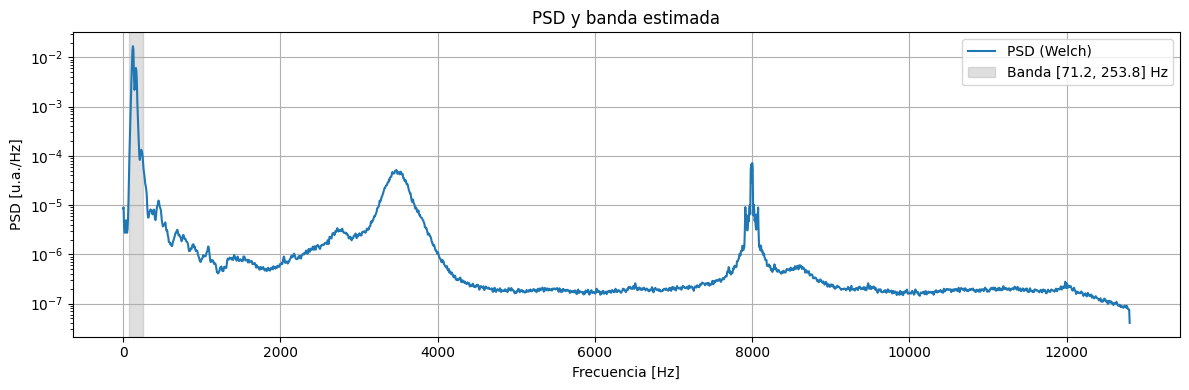

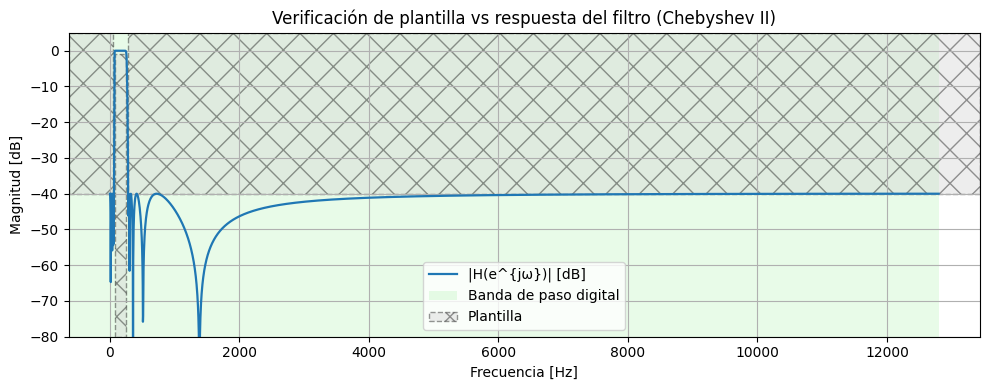

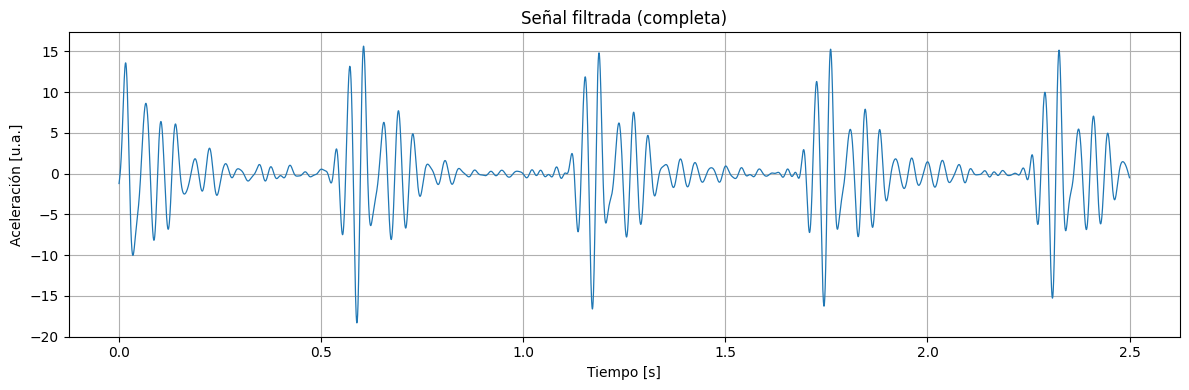

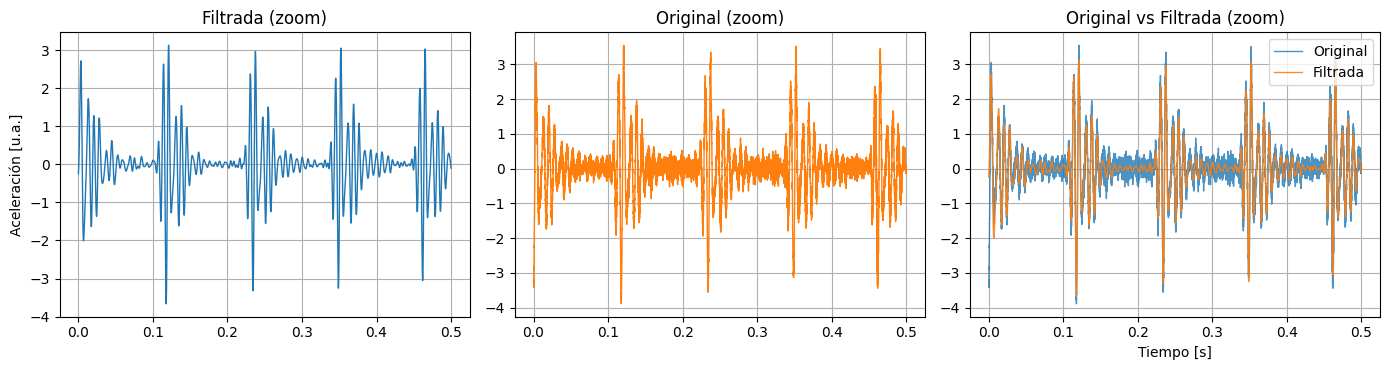

In [112]:

#%% ===========================
# 2) PSD → estimación de banda y filtro Chebyshev II
#=============================
nperseg  = 4096
noverlap = nperseg // 2
window   = get_window('hann', nperseg)

f_psd, Pxx = welch(x_raw, fs=fs, nperseg=nperseg, noverlap=noverlap, window=window)

k_peak = int(np.argmax(Pxx))
total_power = np.trapezoid(Pxx, f_psd)
left = right = k_peak
covered = 0.0
while covered < PSD_COVERAGE * total_power and (left > 0 or right < len(f_psd)-1):
    add_left  = Pxx[left-1]  if left > 0 else -np.inf
    add_right = Pxx[right+1] if right < len(f_psd)-1 else -np.inf
    if add_left >= add_right:
        if left > 0:
            covered += 0.5*(Pxx[left] + Pxx[left-1])*(f_psd[left] - f_psd[left-1])
            left -= 1
        else:
            covered += 0.5*(Pxx[right] + Pxx[right+1])*(f_psd[right+1] - f_psd[right])
            right += 1
    else:
        if right < len(f_psd)-1:
            covered += 0.5*(Pxx[right] + Pxx[right+1])*(f_psd[right+1] - f_psd[right])
            right += 1
        else:
            covered += 0.5*(Pxx[left] + Pxx[left-1])*(f_psd[left] - f_psd[left-1])
            left -= 1

f_lo = max(0.0, f_psd[left])
f_hi = min(fs/2, f_psd[right])
if (f_hi - f_lo) < MIN_BW_HZ:
    c = 0.5*(f_hi + f_lo)
    f_lo = max(0.0, c - MIN_BW_HZ/2)
    f_hi = min(fs/2, c + MIN_BW_HZ/2)

# Plantilla del filtro (márgenes)
margin_pass = 10.0
margin_stop = 30.0
ripple_db   = 1.0
atten_db    = 40.0

fpass = np.array([max(0.5, f_lo - margin_pass), min(fs/2 - 1.0, f_hi + margin_pass)])
fstop = np.array([max(0.1, fpass[0] - margin_stop), min(fs/2 - 1.0, fpass[1] + margin_stop)])

sos = iirdesign(wp=fpass, ws=fstop, gpass=ripple_db, gstop=atten_db,
                ftype='cheby2', output='sos', fs=fs)


#%% ===========================
# 3) Filtrado + envolvente
#=============================
x = sosfiltfilt(sos, x_raw)
env = np.abs(hilbert(x))

n_view = int(min(t_view_sec, t[-1]) * fs)
if n_view <= 0 or n_view > n: n_view = n

# --- FIGURA 1: PSD + banda (igual que antes) ---
plt.figure()
plt.semilogy(f_psd, Pxx, label='PSD (Welch)')
plt.axvspan(fpass[0], fpass[1], color='gray', alpha=0.25,
            label=f'Banda [{fpass[0]:.1f}, {fpass[1]:.1f}] Hz')
plt.title('PSD y banda estimada')
plt.xlabel('Frecuencia [Hz]'); plt.ylabel('PSD [u.a./Hz]')
plt.legend(); plt.tight_layout()

# --- FIGURA 2: Plantilla (pytc2) + respuesta del filtro ---
w, hh = sosfreqz(sos, worN=4096)  # respuesta en frecuencia del IIR
freqs_hz = w/np.pi * (fs/2)

plt.figure(figsize=(10, 4))
plt.plot(freqs_hz, 20*np.log10(np.abs(hh) + 1e-12),
         label='|H(e^{jω})| [dB]', lw=1.6)
plt.title('Verificación de plantilla vs respuesta del filtro (Chebyshev II)')
plt.xlabel('Frecuencia [Hz]'); plt.ylabel('Magnitud [dB]')
plt.ylim([-80, 5]); plt.grid(True)

# Intento de dibujar plantilla con pytc2
try:
    from pytc2.sistemas_lineales import plot_plantilla
    # Usamos los mismos parámetros con los que diseñaste el filtro
    plot_plantilla(filter_type='bandpass',
                   fpass=fpass,
                   ripple=ripple_db,
                   fstop=fstop,
                   attenuation=atten_db,
                   fs=fs)
    plt.legend()
except Exception as e:
    # Si no está pytc2 o falla, dejamos sólo la respuesta del filtro
    print(f"⚠️ No se pudo usar pytc2.plot_plantilla: {e}")
    plt.legend()

plt.tight_layout()

# ===========================
# 3) Filtrado
# ===========================
x = sosfiltfilt(sos, x_raw)
env = np.abs(hilbert(x))

# --- FIGURA 3: Señal filtrada completa ---
plt.figure(figsize=(12, 4))
plt.plot(5*t[:n_view], 5*x[:n_view], lw=0.9)
plt.title('Señal filtrada (completa)')
plt.xlabel('Tiempo [s]'); plt.ylabel('Aceleración [u.a.]')
plt.grid(True); plt.tight_layout()

# --- FIGURA 4: Subplot 1×3 (zoom: filtrada / original / superpuestas) ---
n_view = int(min(t_view_sec, t[-1]) * fs)
if n_view <= 0 or n_view > n:
    n_view = n

fig, axs = plt.subplots(1, 3, figsize=(14, 3.8), sharex=True)

# (1) Filtrada
axs[0].plot(t[:n_view], x[:n_view], lw=1.0)
axs[0].set_title('Filtrada (zoom)')
axs[0].set_ylabel('Aceleración [u.a.]')
axs[0].grid(True)

# (2) Original
axs[1].plot(t[:n_view], x_raw[:n_view], lw=1.0, color='tab:orange')
axs[1].set_title('Original (zoom)')
axs[1].grid(True)

# (3) Superpuestas
axs[2].plot(t[:n_view], x_raw[:n_view], lw=1.0, alpha=0.8, label='Original')
axs[2].plot(t[:n_view], x[:n_view], lw=1.0, alpha=0.9, label='Filtrada')
axs[2].set_title('Original vs Filtrada (zoom)')
axs[2].set_xlabel('Tiempo [s]')
axs[2].grid(True); axs[2].legend(loc='upper right')

plt.tight_layout()





# Teager–Kaiser Energy Operator (TKEO): qué es, cómo funciona y por qué la usamos

## 1) ¿Qué es la TKEO?

La **Teager–Kaiser Energy Operator (TKEO)** es un operador no lineal que estima la **energía instantánea** de una señal **AM–FM** (amplitud y frecuencia que cambian en el tiempo). En **tiempo discreto**, la definimos como:

$$
\Psi\{x[n]\} \;=\; x[n]^2 \;-\; x[n-1]\,x[n+1].
$$

Si la señal puede modelarse como $x[n] = A[n]\cos(\phi[n])$ con $A[n]$ y $\phi'[n]$ variando lentamente, entonces (aprox.):

$$
\Psi\{x[n]\} \;\approx\; A[n]^2 \,\omega[n]^2,
\quad \text{donde } \omega[n] = \phi'[n].
$$

> Interpretación: **responde fuertemente a cambios de energía** (subidas/bajadas rápidas) y a **variaciones de frecuencia instantánea**, típicas de **impactos** que excitan modos resonantes.

---

## 2) Propiedades útiles

- **Sensibilidad a transitorios:** un impacto corta duración + “ringing” en banda → **picos pronunciados** en $\Psi$.
- **Invarianza aproximada a fase:** al trabajar con energía instantánea, la forma **no depende** de la fase del portador.
- **Poca latencia conceptual:** usa sólo $x[n-1], x[n], x[n+1]$ (tres muestras).

**Pero:** la TKEO también **realza ruido de alta frecuencia**; por eso es clave **filtrar en banda** antes y **suavizar** después.

---

## 3) Cómo la implementamos en este proyecto

### (a) Pre-filtrado bandpass
Antes de TKEO, llevamos la señal a su **banda de interés** (estimada por PSD). Esto aumenta la **SNR** de los impactos y reduce falsas activaciones.

### (b) TKEO sobre la señal filtrada
Computamos:
$$
\psi[n] \;=\; \max\!\big(x[n]^2 - x[n-1]x[n+1],\, 0\big).
$$
(Forzamos a $\ge 0$ para evitar valores negativos por discretización/ruido.)

### (c) Suavizado temporal
Aplicamos una **media móvil corta** (p. ej., $0.8$ ms) sobre $\psi[n]$ para estabilizar el trazo:

$$
\tilde\psi[n] \;=\; \big(\psi * h_K\big)[n], \quad h_K = \tfrac{1}{K}\mathbf{1}_K.
$$

### (d) Normalización robusta
Llevamos $\tilde\psi$ a **z-score robusto** usando **mediana/MAD**:
$$
z[n] \;=\; \frac{\tilde\psi[n] - \mathrm{med}(\tilde\psi)}{1.4826\,\mathrm{MAD}(\tilde\psi)}.
$$

> Ventaja: menos sensible a outliers que el z-score clásico (media/desvío).

### (e) Segmentación con histéresis
Usamos **dos umbrales** ($Z_{\text{HI}}$ para abrir, $Z_{\text{LO}}$ para cerrar, con $Z_{\text{LO}}<Z_{\text{HI}}$). Esto evita “parpadeos”:
- Abrimos evento cuando $z[n]\ge Z_{\text{HI}}$,
- Cerramos cuando $z[n]\le Z_{\text{LO}}$.

### (f) Post-procesado temporal
- **Duración mínima**: descartamos parásitos muy breves.
- **Fusión por gap**: unimos sub-tramos muy próximos (mismo impacto).
- **Dilatación** (margen a cada lado): extendemos levemente inicio y fin para **capturar colas** del ringing.

**Resultado:** intervalos **inicio→fin** del **impacto completo**, no sólo el pico.

---

## 4) ¿Por qué TKEO en rodamientos con spall?

- Los defectos tipo **spall** producen **golpes** que excitan **modos resonantes** → transitorios en banda: **exactamente** lo que TKEO resalta.
- A diferencia de umbrales simples o STA/LTA, la TKEO concentra la respuesta en **energía instantánea**, lo que:
  - mejora el contraste en presencia de **amplitud modulada**,
  - brinda **bordes de evento** más naturales (inicio/fin).

---

## 5) Construcción de la plantilla promedio

Con los tramos inicio→fin de TKEO:
1. Extraemos cada evento ($x[s:e]$), quitamos DC y unificamos polaridad (pico positivo).
2. **Normalizamos por pico** (forma unitaria).
3. **Re-muestreamos** cada evento a una **longitud común** $N_{\text{ref}}$.
4. **Promediamos robusto** (mediana) → **forma promedio**.
5. **Re-escalamos una sola vez** por la **mediana de picos** → plantilla en **escala real**.

Esta plantilla sirve para:
- análisis de forma,
- matched filter (comparativo),
- caracterización del daño.

---

## 6) Ventajas, limitaciones y sintonía

**Ventajas**
- Delimita **inicio→fin** del transitorio.
- Robusta a fase del portador.
- Combinada con MAD + histéresis, se adapta a cambios de nivel.

**Limitaciones**
- Sensible a **ruido de alta frecuencia** → el **bandapasa** y el **suavizado** son críticos.
- Umbrales $Z_{\text{HI}}/Z_{\text{LO}}$ requieren **sintonía** (pueden variar con carga/estado).

**Sintonía práctica**
- Si omitís impactos: bajar $Z_{\text{HI}}$ o ampliar el **suavizado**; revisar la **banda** del filtro.
- Si sobran falsos: subir $Z_{\text{HI}}$, aumentar **duración mínima**, o estrechar la **banda**.

---

## 7) En resumen

La TKEO nos da un “microscopio” de **energía instantánea**: detecta y **segmenta** impactos de forma **natural y robusta**. En este proyecto, combinada con **filtrado en banda**, **z-score robusto**, **histéresis** y **post-procesado temporal**, produce eventos **completos** que permiten construir una **plantilla promedio** fiel y, si se desea, comparar contra un **matched filter**.



## Continuamos el procesamiento de la señal

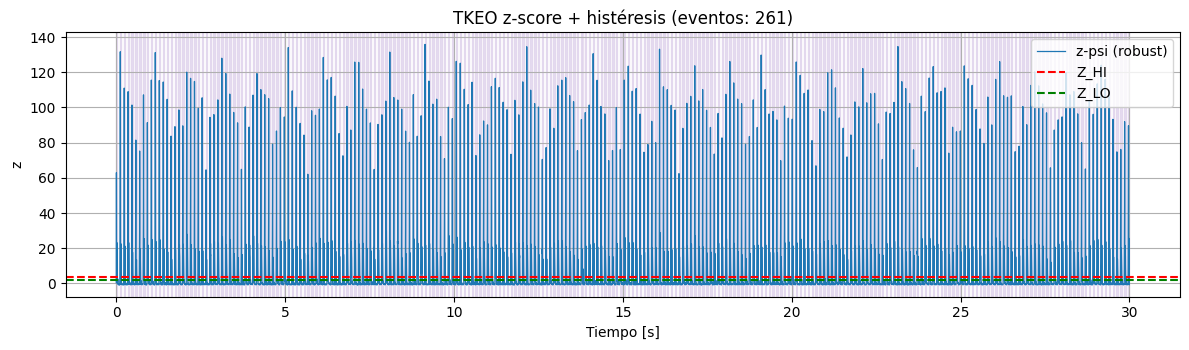

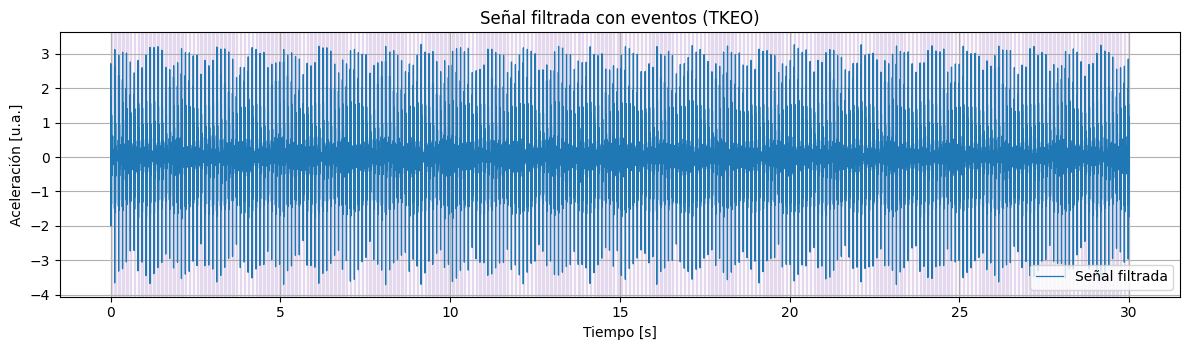

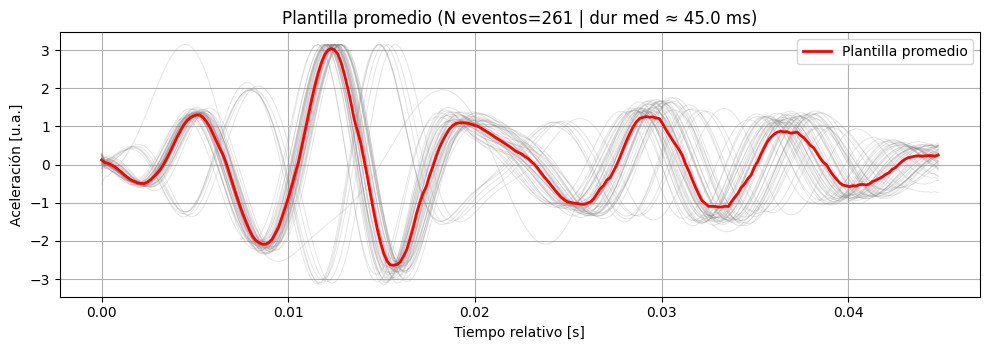

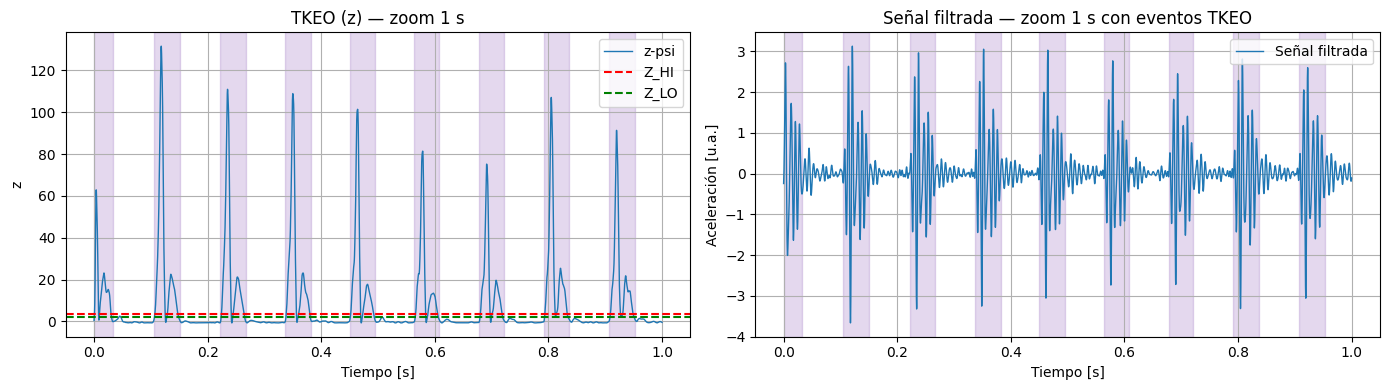

In [113]:
#%% ===========================
# 4) Detector por TKEO + histéresis (marca inicio→fin de cada evento)
#=============================
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

assert 'x' in globals() and 't' in globals() and 'fs' in globals(), "Faltan x, t, fs (corré filtrado)."

# --- 7.1: TKEO (Teager–Kaiser) sobre la señal filtrada ---
x0 = x - np.mean(x)
psi = np.zeros_like(x0)
psi[1:-1] = x0[1:-1]**2 - x0[0:-2]*x0[2:]
psi = np.maximum(psi, 0.0)

# --- 7.2: Suavizado (media móvil) ---
K_ms = 0.8
K = max(5, int(K_ms*1e-3*fs))
psi_s = fftconvolve(psi, np.ones(K)/K, mode='same')

# --- 7.3: z-score robusto (mediana/MAD) ---
eps = 1e-12
med = np.median(psi_s)
mad = np.median(np.abs(psi_s - med)) + eps
z = (psi_s - med) / (1.4826*mad)

# --- 7.4: Histéresis + post-procesado temporal ---
Z_HI, Z_LO = 3.5, 2.2        # umbrales (ajustables)
MIN_DUR_ms = 2.0              # duración mínima
MERGE_GAP_ms = 10.0           # gap para fusionar
DILATE_ms = 2.0               # dilatar bordes para capturar colas

mask_hi = (z >= Z_HI)
mask_lo = (z >= Z_LO)

starts_tkeo, ends_tkeo, open_flag = [], [], False
for i in range(len(z)):
    if not open_flag and mask_hi[i]:
        open_flag = True; starts_tkeo.append(i)
    elif open_flag and not mask_lo[i]:
        open_flag = False; ends_tkeo.append(i)
if open_flag: ends_tkeo.append(len(z)-1)

starts_tkeo = np.array(starts_tkeo, int)
ends_tkeo   = np.array(ends_tkeo,   int)

# duración mínima
min_len = int(MIN_DUR_ms*1e-3*fs)
keep = (ends_tkeo - starts_tkeo + 1) >= max(1, min_len)
starts_tkeo, ends_tkeo = starts_tkeo[keep], ends_tkeo[keep]

# fusión por gap
if len(starts_tkeo) >= 2:
    mg = int(MERGE_GAP_ms*1e-3*fs)
    s2, e2 = [starts_tkeo[0]], [ends_tkeo[0]]
    for s,e in zip(starts_tkeo[1:], ends_tkeo[1:]):
        if s - e2[-1] <= mg: e2[-1] = e
        else: s2.append(s); e2.append(e)
    starts_tkeo, ends_tkeo = np.array(s2, int), np.array(e2, int)

# dilatación (margen a cada lado)
dil = int(DILATE_ms*1e-3*fs)
starts_tkeo = np.maximum(0, starts_tkeo - dil)
ends_tkeo   = np.minimum(len(x)-1, ends_tkeo + dil)

# centros por máximo local (por si luego querés alineaciones finas)
centers_tkeo = np.array(
    [s + int(np.argmax(np.abs(x[s:e+1]))) for s,e in zip(starts_tkeo, ends_tkeo)],
    dtype=int
) if len(starts_tkeo) else np.array([], int)

# --- Plots de control ---
plt.figure(figsize=(12,3.6))
plt.plot(t, z, lw=0.9, label='z-psi (robust)')
plt.axhline(Z_HI, color='r', ls='--', label='Z_HI'); plt.axhline(Z_LO, color='g', ls='--', label='Z_LO')
for s,e in zip(starts_tkeo, ends_tkeo): plt.axvspan(t[s], t[e], color='tab:purple', alpha=0.18)
plt.title(f'TKEO z-score + histéresis (eventos: {len(starts_tkeo)})')
plt.xlabel('Tiempo [s]'); plt.ylabel('z'); plt.grid(True); plt.legend(); plt.tight_layout()

plt.figure(figsize=(12,3.6))
plt.plot(t, x, lw=0.9, label='Señal filtrada')
for s,e in zip(starts_tkeo, ends_tkeo): plt.axvspan(t[s], t[e], color='tab:purple', alpha=0.18)
plt.title('Señal filtrada con eventos (TKEO)')
plt.xlabel('Tiempo [s]'); plt.ylabel('Aceleración [u.a.]')
plt.grid(True); plt.legend(); plt.tight_layout()

#%% ===========================
# 5) Plantilla promedio con ventanas de longitud variable (start→end)
#     - Re-muestrea cada evento a Nref, promedia la forma (mediana) y re-escala 1 sola vez
#=============================
from scipy.signal import resample

Nref = 256    # longitud común para promediar forma (ajustable)
eps  = 1e-12

events_u, peaks = [], []
for s,e in zip(starts_tkeo, ends_tkeo):
    if e - s < 3: continue
    seg = x[s:e+1].astype(float).copy()
    seg -= np.mean(seg)
    pk_idx = int(np.argmax(np.abs(seg)))
    sgn = np.sign(seg[pk_idx]) or 1.0
    seg *= sgn
    pk = np.max(np.abs(seg)) + eps
    seg_u = seg / pk
    seg_u_rs = resample(seg_u, Nref)
    events_u.append(seg_u_rs)
    peaks.append(pk)

events_u = np.array(events_u) if len(events_u) else np.zeros((0, Nref))
peaks    = np.array(peaks)    if len(peaks)    else np.array([])

if len(events_u):
    avg_shape_var = np.median(events_u, axis=0)      # forma promedio (pico≈1)
    amp_med_var   = float(np.median(peaks))          # escala real representativa
    avg_tpl_var   = avg_shape_var * amp_med_var      # plantilla final (escala real)
else:
    avg_shape_var = np.zeros(Nref); amp_med_var = 0.0; avg_tpl_var = np.zeros(Nref)

# eje temporal de la plantilla (usamos duración mediana de eventos)
dur_samples = (ends_tkeo - starts_tkeo + 1) if len(starts_tkeo) else np.array([])
dur_med = int(np.median(dur_samples)) if len(dur_samples) else Nref
tpl_time = np.linspace(0, dur_med/fs, Nref, endpoint=False)

# verificación visual
plt.figure(figsize=(10,3.6))
if len(events_u):
    for i in range(min(50, len(events_u))):
        plt.plot(tpl_time, events_u[i]*amp_med_var, color='gray', alpha=0.2, lw=0.7)
plt.plot(tpl_time, avg_tpl_var, 'r', lw=2.0, label='Plantilla promedio')
plt.title(f'Plantilla promedio (N eventos={len(events_u)} | dur med ≈ {dur_med/fs*1e3:.1f} ms)')
plt.xlabel('Tiempo relativo [s]'); plt.ylabel('Aceleración [u.a.]')
plt.grid(True); plt.legend(); plt.tight_layout()

#%% ===========================
# 6) Zoom 1 s: TKEO (z) y señal filtrada con eventos
#=============================
# elegimos un evento representativo para centrar el zoom
if len(starts_tkeo):
    idx_ref = int(starts_tkeo[0] + np.argmax(np.abs(x[starts_tkeo[0]:ends_tkeo[0]+1])))
else:
    idx_ref = int(np.argmax(np.abs(x)))

W = int(fs)   # 1 segundo
i0 = max(0, idx_ref - W//2)
i1 = min(len(x), i0 + W)
i0 = max(0, i1 - W)

fig, axs = plt.subplots(1, 2, figsize=(14,4), sharex=False)

axs[0].plot(t[i0:i1], z[i0:i1], lw=1.0, label='z-psi')
axs[0].axhline(Z_HI, color='r', ls='--', label='Z_HI'); axs[0].axhline(Z_LO, color='g', ls='--', label='Z_LO')
for s,e in zip(starts_tkeo, ends_tkeo):
    if e < i0 or s > i1: continue
    axs[0].axvspan(t[max(i0,s)], t[min(i1-1,e)], color='tab:purple', alpha=0.25)
axs[0].set_title('TKEO (z) — zoom 1 s'); axs[0].set_xlabel('Tiempo [s]'); axs[0].set_ylabel('z')
axs[0].grid(True); axs[0].legend(loc='upper right')

axs[1].plot(t[i0:i1], x[i0:i1], lw=1.0, label='Señal filtrada')
for s,e in zip(starts_tkeo, ends_tkeo):
    if e < i0 or s > i1: continue
    axs[1].axvspan(t[max(i0,s)], t[min(i1-1,e)], color='tab:purple', alpha=0.25)
axs[1].set_title('Señal filtrada — zoom 1 s con eventos TKEO')
axs[1].set_xlabel('Tiempo [s]'); axs[1].set_ylabel('Aceleración [u.a.]')
axs[1].grid(True); axs[1].legend(loc='upper right')
plt.tight_layout()



## Observaciones de la detección con TKEO

La detección basada en **TKEO** (energía instantánea) permitió **delimitar con precisión los tramos inicio→fin** de cada transitorio impulsivo asociado al daño (impacto + *ringing*), incluso cuando hay variación de amplitud entre eventos. El pipeline de TKEO —filtrado en banda → TKEO → suavizado corto → **z‐score robusto** (mediana/MAD) → **histéresis** (umbral alto/bajo) → posprocesado temporal— logra:
- **Alta sensibilidad** a transitorios cortos y resonantes, con bajo impacto de la fase.
- **Buenas fronteras temporales** (se marcan no solo los picos, sino **todo el evento**).
- **Robustez** frente a cambios lentos de nivel, gracias a la normalización robusta y la histéresis.

### Qué se ve en los gráficos
- Los **sombreados** sobre la señal filtrada cubren **todo el *ringing*** posterior al impacto, no solo el máximo.
- El **trazo TKEO normalizado** exhibe picos definidos y estables que activan/desactivan la detección de forma consistente.
- En presencia de impactos cercanos, la **fusión por gaps** evita fragmentar un mismo evento.

### Tabla de métricas
Para objetivar el desempeño de la detección TKEO sobre cada archivo, reportamos:

| Métrica                             | Descripción                                                                 |
|:------------------------------------|:----------------------------------------------------------------------------|
| **N eventos**                       | Número total de tramos detectados (inicio→fin).                             |
| **Tasa de eventos**                 | $ \frac{N}{T_{\text{señal}}} $ [eventos/s].                                 |
| **Duración media / mediana (ms)**   | Longitud de los tramos; idealmente acotada y consistente.                   |
| **IQR de duración (ms)**            | Dispersión robusta de duraciones (calidad de segmentación).                 |
| **Cobertura temporal (%)**          | % del tiempo total cubierto por eventos (actividad impulsiva).              |
| **Amplitud pico mediana**           | Mediana de picos (o envolvente) dentro de tramos (severidad típica).        |
| **Latencia al pico (ms)**           | Tiempo desde inicio del tramo TKEO hasta el pico (consistencia temporal).   |


### Lectura rápida de resultados (ejemplo de interpretación)
- **Cobertura moderada y tasa estable:** sugiere un régimen de impactos repetitivos consistente con el defecto.
- **Duración con baja dispersión (IQR pequeño):** indica que el posprocesado captura de forma **estable** el *ringing* típico.
- **Amplitud pico mediana elevada:** coherente con mayor severidad/energía en los eventos.
- **Alta validación por similitud (opcional):** confirma que la mayoría de tramos comparten una **misma firma** (plantilla).

### Limitaciones y controles
- Si aparecen **microtramos espurios**, aumentar la **duración mínima** o el **suavizado** sobre TKEO.
- Si se “recortan colas”, incrementar la **dilatación** de bordes o revisar la **banda de filtrado** (PSD→fpass).
- Si hay **subdetección** en zonas de bajo SNR, reducir levemente el umbral alto o ajustar el **z‐score robusto**.

**Conclusión.** La detección con TKEO entrega una **segmentación temporal fiable** de los impactos, base necesaria para:
1) construir una **plantilla promedio** representativa (forma unitaria + re‐escala única), y  
2) extraer **indicadores tiempo–frecuencia** (CWT) por evento que cuantifican la firma del daño.


## ¿Qué es el IQR (Interquartile Range)?

El **IQR** (*rango intercuartílico*) es una medida **robusta de dispersión** que cuantifica cuánto se extiende la parte “central” de los datos.  
Se define como la diferencia entre el **tercer cuartil** y el **primer cuartil**:

- **Q1 (25%)**: el valor por debajo del cual cae el 25% de los datos.  
- **Q2 (50%)**: la **mediana**.  
- **Q3 (75%)**: el valor por debajo del cual cae el 75% de los datos.  

$$
\text{IQR} = Q_3 - Q_1
$$

### ¿Por qué es útil?
- **Robusto a outliers**: al basarse en cuartiles, ignora extremos y describe mejor la **variabilidad típica** en distribuciones sesgadas o con valores atípicos.
- **Complementa a la mediana**: mientras la mediana resume la **tendencia central**, el IQR resume la **dispersión central**.
- **Base de boxplots**: en un gráfico de caja, la “caja” va de **Q1** a **Q3** y su altura es el **IQR**.

### Detección de outliers (regla de Tukey)
Se consideran **outliers** los puntos que quedan fuera de los **límites**:
- Límite inferior: $Q_1 - 1.5 \cdot \text{IQR}$  
- Límite superior: $Q_3 + 1.5 \cdot \text{IQR}$

(Para **outliers extremos** a veces se usa $3\cdot\text{IQR}$).

> Nota: el cálculo de cuartiles puede variar levemente según el método de interpolación elegido (NumPy, Pandas, etc.). Lo importante es **ser consistente** dentro del análisis.



In [114]:
#%% ===========================
# Tabla de métricas a partir de TKEO (resumen + por evento)
# Requisitos previos: x (señal filtrada), t, fs, starts_tkeo, ends_tkeo
#=============================
import numpy as np
import pandas as pd

# --- chequeos básicos ---
assert 'x' in globals() and 't' in globals() and 'fs' in globals(), "Faltan x, t, fs."
assert 'starts_tkeo' in globals() and 'ends_tkeo' in globals(), "Faltan starts_tkeo / ends_tkeo."

starts_tkeo = np.asarray(starts_tkeo, dtype=int)
ends_tkeo   = np.asarray(ends_tkeo,   dtype=int)

# ordenar y sanear (por si acaso)
ord_idx = np.argsort(starts_tkeo)
starts_tkeo = starts_tkeo[ord_idx]
ends_tkeo   = ends_tkeo[ord_idx]
# recortar a pares válidos
mask_valid = (starts_tkeo >= 0) & (ends_tkeo >= starts_tkeo) & (ends_tkeo < len(x))
starts_tkeo = starts_tkeo[mask_valid]
ends_tkeo   = ends_tkeo[mask_valid]

N = len(starts_tkeo)
T_total_s = len(x) / fs

if N == 0:
    print("[TKEO] No hay eventos detectados para tabular.")
    tabla_resumen = pd.DataFrame([{
        "N_eventos": 0, "tasa_eventos_[1/s]": 0.0, "dur_media_ms": np.nan, "dur_mediana_ms": np.nan,
        "dur_IQR_ms": np.nan, "cobertura_%": 0.0, "amp_pico_mediana": np.nan, "latencia_pico_mediana_ms": np.nan
    }])
    display(tabla_resumen)
else:
    # --- Duraciones (ms) ---
    dur_muestras = (ends_tkeo - starts_tkeo + 1).astype(int)
    dur_ms = dur_muestras / fs * 1e3

    # --- Cobertura temporal (% del tiempo ocupado por eventos) ---
    cobertura_pct = (dur_muestras.sum() / len(x)) * 100.0

    # --- Amplitud pico por evento ---
    # Preferimos envolvente si está disponible; si no, usamos |x| o calculamos Hilbert rápidamente.
    if 'env' in globals():
        amp_pico = np.array([np.max(env[s:e+1]) for s, e in zip(starts_tkeo, ends_tkeo)], dtype=float)
    else:
        # alternativa rápida: pico de |x| en cada evento
        amp_pico = np.array([np.max(np.abs(x[s:e+1])) for s, e in zip(starts_tkeo, ends_tkeo)], dtype=float)

    # --- Latencia al pico (ms) dentro de cada tramo ---
    lat_pico_ms = []
    for s, e in zip(starts_tkeo, ends_tkeo):
        i_loc = np.argmax(np.abs(x[s:e+1]))
        lat_pico_ms.append(i_loc / fs * 1e3)
    lat_pico_ms = np.asarray(lat_pico_ms, dtype=float)

    # --- Estadísticos robustos ---
    def med_iqr(v):
        v = np.asarray(v, float)
        if v.size == 0:
            return np.nan, np.nan
        q1, med, q3 = np.percentile(v, [25, 50, 75])
        return float(med), float(q3 - q1)

    dur_med, dur_iqr = med_iqr(dur_ms)
    amp_med, amp_iqr = med_iqr(amp_pico)
    lat_med, lat_iqr = med_iqr(lat_pico_ms)

    # --- Tasa de eventos ---
    tasa_ev = N / T_total_s

    # ===== Tabla resumen (una fila) =====
    tabla_resumen = pd.DataFrame([{
        "N_eventos": N,
        "tasa_eventos_[1/s]": tasa_ev,
        "dur_media_ms": float(np.mean(dur_ms)),
        "dur_mediana_ms": dur_med,
        "dur_IQR_ms": dur_iqr,
        "cobertura_%": cobertura_pct,
        "amp_pico_mediana": amp_med,
        "latencia_pico_mediana_ms": lat_med
    }])

    # ===== Tabla por evento =====
    tabla_eventos = pd.DataFrame({
        "evento": np.arange(1, N+1, dtype=int),
        "t_ini_s": t[starts_tkeo],
        "t_fin_s": t[ends_tkeo],
        "dur_ms": dur_ms,
        "amp_pico": amp_pico,
        "latencia_pico_ms": lat_pico_ms
    })

    # Mostrar
    print("[TKEO] Resumen de métricas")
    display(tabla_resumen.round(3))

    print("[TKEO] Métricas por evento (primeras filas)")
    display(tabla_eventos.head(10).round(3))


[TKEO] Resumen de métricas


,N_eventos,tasa_eventos_[1/s],dur_media_ms,dur_mediana_ms,dur_IQR_ms,cobertura_%,amp_pico_mediana,latencia_pico_mediana_ms
0,261,8.7,44.665,45.0,1.602,38.859,3.276,12.344


[TKEO] Métricas por evento (primeras filas)


,evento,t_ini_s,t_fin_s,dur_ms,amp_pico,latencia_pico_ms
0,1,0.000,0.033,32.656,3.029,3.242
1,2,0.105,0.151,45.820,3.706,12.695
2,3,0.222,0.267,44.805,3.401,11.953
3,4,0.336,0.382,46.055,3.392,12.461
4,5,0.450,0.495,45.430,3.277,11.992
5,6,0.564,0.608,43.867,2.968,15.352
6,7,0.678,0.721,43.125,2.822,12.266
7,8,0.792,0.836,44.609,3.372,12.656
8,9,0.907,0.953,45.625,3.118,12.266
9,10,1.025,1.070,44.805,3.496,12.148


# Marco teórico: Transformada Wavelet Continua (CWT)

## ¿Qué es?
La **CWT** (Continuous Wavelet Transform) descompone una señal en copias **escaladas** (ancho variable) y **trasladadas** (tiempo variable) de una **wavelet madre**. Permite ver **cuándo** y **en qué frecuencias** aparece la energía.

## Definición
La CWT de una señal $x(t)$ se define como:
$$
W_x(a,b) \;=\; \int_{-\infty}^{\infty} x(t)\,\frac{1}{\sqrt{|a|}}\,
\psi^{*}\!\left(\frac{t-b}{a}\right)\,dt
$$
- $a$: **escala** (inversamente proporcional a frecuencia)
- $b$: **traslación temporal**
- $\psi$: **wavelet madre** (por ej., Morlet), y $\psi^{*}$ su conjugada

El **escalograma** es la potencia tiempo–escala:
$$
\text{Scalogram}(a,b) \;=\; |W_x(a,b)|^2
$$

## Escala ↔ Frecuencia
Para una wavelet con **frecuencia central** $f_c$ y muestreo $\Delta t$:
$$
f \;\approx\; \frac{f_c}{a\,\Delta t}
$$
(escala chica $\Rightarrow$ frecuencia alta; escala grande $\Rightarrow$ frecuencia baja).

## ¿Por qué CWT y no solo STFT?
- **STFT**: ventana de tamaño **fijo** ⇒ resolución tiempo–frecuencia constante.
- **CWT**: **multirresolución**  
  - mejor resolución **temporal** en **altas** frecuencias,  
  - mejor resolución **frecuencial** en **bajas** frecuencias.  
Ideal para **transitorios** (impactos + “ringing” en banda).

## Wavelet madre (Morlet)
La **Morlet** (gaussiana modulada) es común en vibraciones porque:
- perfila bien **modos resonantes**,
- entrega un escalograma suave y fácil de interpretar,
- facilita el mapeo escala→frecuencia via $f_c$.

## Parámetros prácticos (lo que usamos en el informe)
- **Banda de interés**: limitar el análisis a $[f_{\text{min}}, f_{\text{max}}]$ estimado con PSD.
- **Voces por octava** (resolución en $f$): típico 12–32 (usamos 24).
- **Contraste del escalograma**: restar **fondo por escala** (mediana) y aplicar **clip por percentiles** para evitar “manchones” saturados.
- **Zoom por evento**: mostrar un **evento** y también una **ventana de 1 s** con todos los eventos.
- **Alineación/normalización**: re-muestrear eventos a una duración común para **promediar firmas** tiempo–frecuencia.

## ¿Qué aporta en rodamientos con spall?
- Localiza **cuándo** aparece el impacto y **qué frecuencia** domina el *ringing*.
- Permite **afinar el pasabanda** (filtros) observando la banda resonante real.
- Mide **ancho de banda** y **decaimiento** (relacionados con amortiguamiento/Q).
- Ayuda a **diferenciar** tipos de eventos (patrones distintos en el escalograma).

## Diferencia con DWT (discreta)
- **CWT**: densa/continua (redundante), muy informativa para diagnóstico.
- **DWT**: banco de filtros en potencias de 2 (compacta), útil para compresión/denoise, menos “fina” para firmas tiempo–frecuencia.

**En síntesis:** la CWT es una lupa tiempo–frecuencia **multirresolución** que destaca transitorios en la banda correcta. Esto nos da una idea de como es la frecuencia en un cierto rango temporal. 

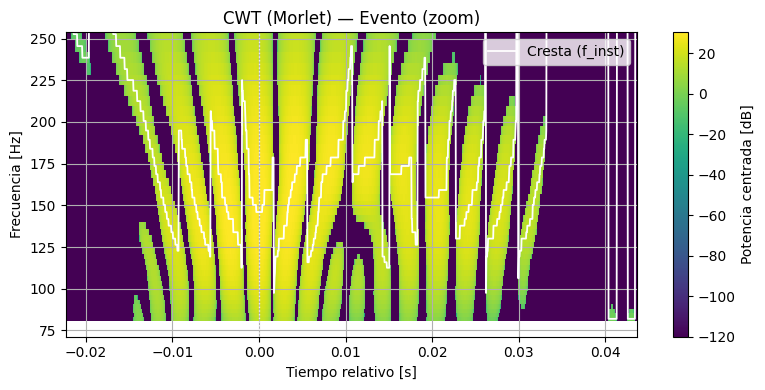

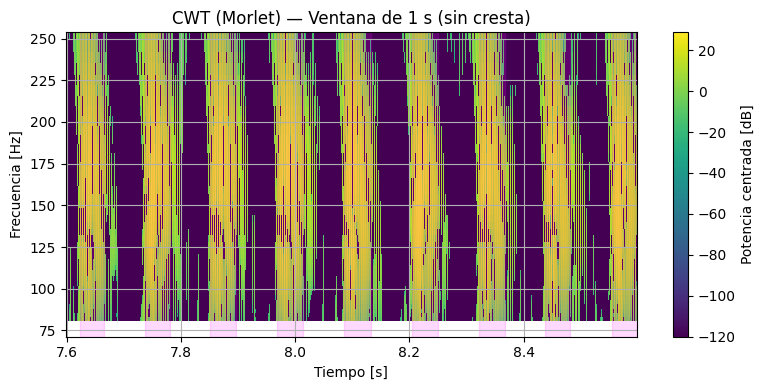

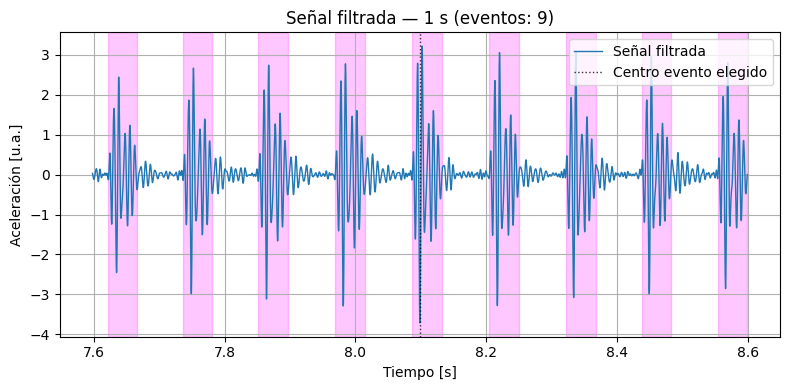

In [115]:
#%% ===========================
# 10A-ter) CWT (Morlet) de UN evento (zoom) + CWT del segundo completo + señal en 1 s
#           Panel 1: escalograma del evento (zoom, contraste mejorado + cresta)
#           Panel 2: escalograma de la ventana de 1 s
#           Panel 3: señal filtrada en 1 s con TODOS los eventos sombreados
#=============================
import numpy as np
import matplotlib.pyplot as plt
import pywt

assert 'x' in globals() and 't' in globals() and 'fs' in globals(), "Faltan x, t, fs."
assert 'fpass' in globals(), "Falta fpass (banda del pasabanda)."
assert 'starts_tkeo' in globals() and 'ends_tkeo' in globals(), "Faltan eventos TKEO (bloque 7)."

# ---- 1) Elegimos un evento representativo (mayor pico) ----
if len(starts_tkeo):
    pk_vals = [np.max(np.abs(x[s:e+1])) for s, e in zip(starts_tkeo, ends_tkeo)]
    k_best = int(np.argmax(pk_vals))
    s0, e0 = int(starts_tkeo[k_best]), int(ends_tkeo[k_best])
else:
    s0, e0 = 0, min(len(x)-1, int(fs))  # fallback

# Centro del evento (pico absoluto dentro de [s0, e0])
c_best = s0 + int(np.argmax(np.abs(x[s0:e0+1])))

# ---- 2) Ventana de 1 s alrededor del centro (para paneles 2 y 3) ----
W = int(fs)  # 1 segundo
i0 = max(0, c_best - W//2)
i1 = min(len(x), i0 + W)
i0 = max(0, i1 - W)  # asegurar 1 s si hay espacio

# ---- 3) Segmento corto para CWT del evento (margen chico para no mezclar) ----
M_ms = 10.0                # margen ± en ms
M = int(M_ms * 1e-3 * fs)
ss = max(0, s0 - M)
ee = min(len(x), e0 + M)
x_ev = x[ss:ee]
t_ev = t[ss:ee] - t[c_best]   # tiempo relativo centrado en el evento

# ---- 4) Definimos malla CWT en la banda de interés ----
fmin, fmax = max(1.0, fpass[0]), min(fs/2*0.95, fpass[1])
n_vo   = 24                       # voces por octava (resolución en f)
wavelet = 'morl'
fc = pywt.central_frequency(wavelet)
dt = 1.0 / fs

n_oct   = np.log2(fmax / fmin)
n_scales = int(np.ceil(n_vo * n_oct)) + 1
freqs   = fmin * 2**(np.linspace(0, n_oct, n_scales))
scales  = fc / (freqs * dt)

# ---- 5) CWT del evento (panel 1) con mejora de contraste ----
coef_ev, scales_ev = pywt.cwt(x_ev, scales, wavelet, sampling_period=dt)
power_ev = np.abs(coef_ev)**2
freqs_cwt = pywt.scale2frequency(wavelet, scales_ev) / dt

# resta de fondo por escala y clip robusto
bg_ev    = np.median(power_ev, axis=1, keepdims=True)
pow_ev_c = np.maximum(power_ev - bg_ev, 0.0)
pow_ev_db = 10*np.log10(pow_ev_c + 1e-12)
vmin_ev = np.percentile(pow_ev_db, 5.0)
vmax_ev = np.percentile(pow_ev_db, 99.5)

ridge_idx_ev = np.argmax(pow_ev_c, axis=0)
ridge_f_ev   = freqs_cwt[ridge_idx_ev]

# ---- 6) CWT de la ventana de 1 s (panel 2) ----
x_win = x[i0:i1]
t_win = t[i0:i1]   # mantenemos tiempo absoluto para alinear con panel 3

coef_w1, scales_w1 = pywt.cwt(x_win, scales, wavelet, sampling_period=dt)
power_w1 = np.abs(coef_w1)**2
# mismo eje de frecuencias (scales iguales ⇒ freqs iguales)
freqs_cwt_w1 = pywt.scale2frequency(wavelet, scales_w1) / dt

# resta de fondo por escala y clip robusto (independiente del panel 1)
bg_w1     = np.median(power_w1, axis=1, keepdims=True)
pow_w1_c  = np.maximum(power_w1 - bg_w1, 0.0)
pow_w1_db = 10*np.log10(pow_w1_c + 1e-12)
vmin_w1 = np.percentile(pow_w1_db, 5.0)
vmax_w1 = np.percentile(pow_w1_db, 99.5)

ridge_idx_w1 = np.argmax(pow_w1_c, axis=0)
ridge_f_w1   = freqs_cwt_w1[ridge_idx_w1]

# ===== Figura 1: CWT (Morlet) del EVENTO (zoom) + cresta =====
plt.figure(figsize=(8, 4))
im0 = plt.pcolormesh(t_ev, freqs_cwt, pow_ev_db, shading='auto', vmin=vmin_ev, vmax=vmax_ev)
plt.plot(t_ev, ridge_f_ev, 'w', lw=1.3, label='Cresta (f_inst)')
plt.axvline(0, color='w', ls=':', lw=1.0, alpha=0.8)
plt.ylim(fmin, fmax)
plt.xlabel('Tiempo relativo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.title('CWT (Morlet) — Evento (zoom)')
plt.legend(loc='upper right')
cbar0 = plt.colorbar(im0); cbar0.set_label('Potencia centrada [dB]')
plt.tight_layout()

# ===== Figura 2: CWT (Morlet) de la ventana de 1 s (SIN cresta) =====
plt.figure(figsize=(8, 4))
im1 = plt.pcolormesh(t_win, freqs_cwt_w1, pow_w1_db, shading='auto', vmin=vmin_w1, vmax=vmax_w1)
# sombrear eventos dentro del segundo
for s, e in zip(starts_tkeo, ends_tkeo):
    if e < i0 or s > i1:
        continue
    s_clip = max(s, i0); e_clip = min(e, i1 - 1)
    plt.axvspan(t[s_clip], t[e_clip], color='magenta', alpha=0.15)
plt.ylim(fmin, fmax)
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.title('CWT (Morlet) — Ventana de 1 s (sin cresta)')
cbar1 = plt.colorbar(im1); cbar1.set_label('Potencia centrada [dB]')
plt.tight_layout()

# ===== Figura 3: Señal filtrada en 1 s con TODOS los eventos sombreados =====
plt.figure(figsize=(8, 4))
plt.plot(t[i0:i1], x[i0:i1], lw=1.0, label='Señal filtrada')
count_ev = 0
for s, e in zip(starts_tkeo, ends_tkeo):
    if e < i0 or s > i1:
        continue
    s_clip = max(s, i0); e_clip = min(e, i1 - 1)
    plt.axvspan(t[s_clip], t[e_clip], color='magenta', alpha=0.22)
    count_ev += 1
# marcar el centro del evento representativo (si cae en la ventana)
if i0 <= c_best < i1:
    plt.axvline(t[c_best], color='k', ls=':', lw=1.0, alpha=0.8, label='Centro evento elegido')

plt.title(f'Señal filtrada — 1 s (eventos: {count_ev})')
plt.xlabel('Tiempo [s]')
plt.ylabel('Aceleración [u.a.]')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()



# Métricas tiempo–frecuencia por evento (CWT) y conclusiones

En esta sección cuantificamos, **por evento** (inicio→fin detectado con TKEO), los siguientes indicadores basados en la CWT con wavelet **Morlet**:

- **f₀ (Hz):**          frecuencia dominante del *ringing* (mediana sobre el evento).
- **BW (Hz):**          ancho de banda a −6 dB alrededor de f₀ (mediana sobre el evento).
- **Q:**                factor de calidad aproximado ($Q \approx f_0 / \text{BW}$).
- **Energía (dB):**     energía integrada del escalograma centrado por escala.
- **τ₋₂₀dB (ms):**      tiempo de decaimiento de la potencia (desde el pico hasta −20 dB).
- **Duración (ms):**    longitud del evento (TKEO).

Luego generamos:  
1) una **tabla** con las métricas por evento,  
2) **resúmenes** (mediana/IQR), e  
3) **gráficos** (histogramas/boxplots) para reportar en el informe.


In [ ]:
# ==========================
# CWT por evento + métricas (versión robusta)
#  - más voces por octava
#  - suavizado por escala
#  - BW por momentos (FWHM ~ 2*sqrt(2*ln2)*sigma_f)
#  - τ_-20dB con suavizado temporal
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import pywt
except Exception as e:
    raise RuntimeError("Falta PyWavelets. Instalá con:  %pip install PyWavelets") from e

# --------- Requisitos previos ---------
assert 'x' in globals() and 't' in globals() and 'fs' in globals(), "Faltan x, t, fs."
assert 'fpass' in globals(), "Falta fpass (banda del pasabanda)."
assert 'starts_tkeo' in globals() and 'ends_tkeo' in globals(), "Faltan eventos TKEO."

# --------- Parámetros CWT y medición ---------
fmin, fmax = max(1.0, float(fpass[0])), min(float(fs)/2*0.95, float(fpass[1]))
n_vo      = 36                     # ↑ resolución en frecuencia (antes 24)
wavelet   = 'morl'
fc        = pywt.central_frequency(wavelet)
dt        = 1.0 / fs

# malla de escalas (log en frecuencia)
n_oct    = np.log2(fmax/fmin) if fmax > fmin else 1.0
n_scales = int(np.ceil(n_vo * n_oct)) + 1
freqs    = fmin * 2**(np.linspace(0, n_oct, n_scales))
scales   = fc / (freqs * dt)

# Umbrales y constantes
EPS        = 1e-12
MIN_LEN    = 5          # mínimo de muestras por evento
DECAY_DB   = 20.0       # para τ_-20dB
Lscale     = 7          # tamaño del kernel de suavizado en escala (impar)
Lt_ms      = 0.4        # suavizado temporal para τ_-20dB (ms)

# Kernel de suavizado por escala (Hann)
ker = np.hanning(Lscale)
ker /= ker.sum()

rows = []
for k, (s, e) in enumerate(zip(starts_tkeo, ends_tkeo), start=1):
    s = int(s); e = int(e)
    if e - s + 1 < MIN_LEN:
        continue

    # Segmento de evento (quitamos DC local)
    seg = x[s:e+1].astype(float).copy()
    seg -= np.mean(seg)
    seg_t = t[s:e+1]
    nseg  = len(seg)

    # CWT del evento
    coef, scales_ev = pywt.cwt(seg, scales, wavelet, sampling_period=dt)
    P = np.abs(coef)**2                        # potencia tiempo–escala (Nscales x Ntime)

    # Centramos por escala (quitamos fondo) y SUAVIZAMOS a lo largo de escala
    bg = np.median(P, axis=1, keepdims=True)
    P_ctr = np.maximum(P - bg, 0.0)            # >= 0
    # suavizado en escala (convolución por columna)
    P_s = np.apply_along_axis(lambda v: np.convolve(v, ker, mode='same'), 0, P_ctr)

    # Frecuencias equivalentes para cada escala
    f_sc = pywt.scale2frequency(wavelet, scales_ev) / dt  # Hz  (vector de tamaño Nscales)

    # (1) Frecuencia dominante por instante (ridge sobre P_s) y f0 del evento
    ridge_idx = np.argmax(P_s, axis=0)              # índice de escala por columna
    ridge_f   = f_sc[ridge_idx]                     # Hz
    f0_med = float(np.median(ridge_f))
    f0_std = float(np.std(ridge_f, ddof=1)) if len(ridge_f) > 1 else 0.0

    # (2) Ancho de banda por momentos (varianza ponderada alrededor de mu_f)
    #     FWHM ~ 2*sqrt(2*ln2)*sigma_f  (si perfil ~gaussiano)
    W = P_s                                        # pesos (potencia suavizada)
    sumW = W.sum(axis=0) + EPS
    mu_f = (W * f_sc[:, None]).sum(axis=0) / sumW
    var_f = (W * (f_sc[:, None] - mu_f[None, :])**2).sum(axis=0) / sumW
    sigma_f = np.sqrt(np.maximum(var_f, 0.0))
    BW_gauss = 2.0 * np.sqrt(2.0 * np.log(2.0)) * sigma_f
    BW_med  = float(np.median(BW_gauss)) if len(BW_gauss) else 0.0

    # (3) Q ≈ f0 / BW (evitar divisiones por cero)
    Q_med = float(f0_med / BW_med) if BW_med > 0 else np.nan

    # (4) Energía del evento (dB) con P_ctr
    E_lin = float(np.sum(P_ctr))
    Energy_dB = 10*np.log10(E_lin + EPS)

    # (5) τ_-20dB: potencia pico por tiempo (suavizada) y tiempo de caída a -20 dB
    p_t = P_s.max(axis=0)                           # pico por tiempo (suavizado por escala)
    # suavizado temporal leve
    Lt = max(3, int(Lt_ms * 1e-3 * fs))
    if Lt > 1:
        p_t = np.convolve(p_t, np.ones(Lt)/Lt, mode='same')
    p_t /= (p_t.max() + EPS)                        # normalizada a 1
    p_db = 10*np.log10(p_t + EPS)                   # dB relativos al pico (<= 0)
    j_pk = int(np.argmax(p_t))
    idx = np.where(p_db[j_pk:] <= -DECAY_DB)[0]
    tau_ms = float(idx[0]/fs*1e3) if len(idx) else np.nan

    # (6) Duración (ms) del evento (TKEO)
    dur_ms = float((e - s + 1)/fs*1e3)
    t0 = float(t[s]); t1 = float(t[e])

    rows.append(dict(
        evento=k, t_ini=t0, t_fin=t1, dur_ms=dur_ms,
        f0_Hz_med=f0_med, f0_Hz_std=f0_std,
        BW_Hz_med=BW_med, Q_med=Q_med,
        Energy_dB=Energy_dB, Decay20dB_ms=tau_ms
    ))

df_cwt = pd.DataFrame(rows)

# Mostrar primeras filas y resumen
display(df_cwt.head(10))
print(f"\n[Métricas CWT] eventos medidos: {len(df_cwt)}")

if len(df_cwt):
    def _sumstat(a):
        a = np.asarray(a, float)
        a = a[np.isfinite(a)]
        if not len(a): return dict(med=np.nan, iqr=np.nan)
        q1, med, q3 = np.percentile(a, [25, 50, 75])
        return dict(med=med, iqr=(q3-q1))
    s_f0   = _sumstat(df_cwt['f0_Hz_med'])
    s_bw   = _sumstat(df_cwt['BW_Hz_med'])
    s_q    = _sumstat(df_cwt['Q_med'])
    s_e    = _sumstat(df_cwt['Energy_dB'])
    s_tau  = _sumstat(df_cwt['Decay20dB_ms'])

    print(f"  f0 (Hz): med={s_f0['med']:.1f}, IQR={s_f0['iqr']:.1f}")
    print(f"  BW (Hz): med={s_bw['med']:.2f}, IQR={s_bw['iqr']:.2f}")
    print(f"  Q      : med={s_q['med']:.2f}, IQR={s_q['iqr']:.2f}")
    print(f"  Energía (dB): med={s_e['med']:.1f}, IQR={s_e['iqr']:.1f}")
    print(f"  τ_-20dB (ms): med={s_tau['med']:.2f}, IQR={s_tau['iqr']:.2f}")



# ==========================
# Gráficos de las métricas
# ==========================
import matplotlib.pyplot as plt
import numpy as np

if len(df_cwt):
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.ravel()

    # Hist f0
    axs[0].hist(df_cwt['f0_Hz_med'].dropna(), bins=24)
    axs[0].set_title('f₀ (Hz)'); axs[0].set_xlabel('Hz'); axs[0].set_ylabel('conteo'); axs[0].grid(True)

    # Hist BW
    axs[1].hist(df_cwt['BW_Hz_med'].dropna(), bins=24)
    axs[1].set_title('BW (Hz)'); axs[1].set_xlabel('Hz'); axs[1].grid(True)

    # Hist Q
    axs[2].hist(df_cwt['Q_med'].replace([np.inf, -np.inf], np.nan).dropna(), bins=24)
    axs[2].set_title('Q'); axs[2].set_xlabel('—'); axs[2].grid(True)

    # Hist energía
    axs[3].hist(df_cwt['Energy_dB'].dropna(), bins=24)
    axs[3].set_title('Energía (dB)'); axs[3].set_xlabel('dB'); axs[3].grid(True)

    # Hist tau -20 dB
    axs[4].hist(df_cwt['Decay20dB_ms'].dropna(), bins=24)
    axs[4].set_title('τ₋₂₀dB (ms)'); axs[4].set_xlabel('ms'); axs[4].grid(True)

    # Duración de eventos
    axs[5].hist(df_cwt['dur_ms'].dropna(), bins=24)
    axs[5].set_title('Duración evento (ms)'); axs[5].set_xlabel('ms'); axs[5].grid(True)

    plt.tight_layout()



## Resultados e interpretación de indicadores

A continuación se detallan los indicadores que extraemos por evento y **cómo leer sus histogramas** para traducirlos en conclusiones físicas sobre el sistema (spall/guía, excitación y amortiguamiento).

---

### 1) Presencia de energía en **banda resonante** (CWT)

**Qué mide:**  
La CWT concentra potencia **sólo durante los impactos** y dentro de una **banda de frecuencia** coherente con la resonancia excitada por el daño. Esto valida el **pasabanda** usado en el preprocesado (PSD→fpass).

**Cómo se ve:**  
- En el escalograma, “manchas” compactas en $[f_{\min}, f_{\max}]$ cuando hay evento.  
- Fuera de los impactos, el fondo (tras restar mediana por escala) queda bajo.

**Lectura práctica:**  
- Si el brillo se mantiene dentro de la banda esperada → **filtro bien afinado**.  
- Si la energía se corre de banda → conviene **ajustar fpass** (o revisar el estado mecánico: cambios de rigidez/carga).  
- No se suele resumir con histogramas, pero su **consistencia visual** respalda las métricas siguientes.

---

### 2) **Frecuencia dominante $f_0$** del *ringing*

**Qué mide:**  
La “portadora” del transitorio. Se obtiene del **lomo** (ridge) en la CWT: frecuencia con máxima potencia por instante y su **mediana** por evento.

**Cómo leer el histograma de $f_0$:**  
- **Pico estrecho** y centrado → **firma resonante estable**.  
- **Ancho (IQR grande)** → variabilidad de contacto/carga o presencia de **multimodo**.  
- **Sesgo (cola a un lado)** → eventos ocasionalmente más bajos/altos en frecuencia (cambios intermittentes).  
- **Multimodalidad** (dos o más picos) → posibles **modos distintos** excitados en diferentes impactos.

**Resultado (de la corrida):** `f0_med = 170.3 Hz (IQR = 3.3 Hz)`  
→ Frecuencia muy estable; buena base para comparar condiciones.

---

### 3) **Ancho de banda (BW)** y **factor de calidad $Q \approx f_0/\text{BW}$**

**Qué miden:**  
- **BW**: extensión espectral del *ringing* alrededor de $f_0$ (−6 dB o por momentos).  
- **Q**: medida adimensional del “afilado” resonante. **Q alto** = amortiguamiento bajo; **Q bajo** = amortiguamiento alto.

**Cómo leer los histogramas:**  
- **BW estrecho / Q alto** → resonancia “limpia”, **poco amortiguada**.  
- **BW ancho / Q bajo** → **más amortiguamiento** o “ensuciamiento” modal.  
- **Colas largas** → impactos atípicos (choques más duros/suaves).  
- **Multimodalidad** → distintos regímenes (p. ej., por cambios de velocidad/carga).

**Resultado:** `BW_med = 52.00 Hz`, `Q_med = 3.30`  
→ Resonancia moderadamente amortiguada; si BW baja y Q sube en otra condición, el sistema “ringea” más tiempo (menor disipación).

---

### 4) **Energía del evento (dB)** y **tiempo de decaimiento $\tau_{-20\text{dB}}$**

**Qué miden:**  
- **Energía (dB)**: potencia integrada del escalograma (centrado por escala) durante el evento.  
- **$\tau_{-20\text{dB}}$**: tiempo desde el pico hasta caer 20 dB (proxy de amortiguamiento temporal).

**Cómo leer los histogramas:**  
- **Energía alta** → impactos más **severos** o **acoplo** más eficiente a la resonancia.  
- **$\tau_{-20\text{dB}}$ largo** → *ringing* **persistente** (amortiguamiento bajo); corto → **rápido** (amortiguamiento alto).  
- **Sesgo en energía** → mezcla de impactos fuertes y débiles (contacto irregular).  
- **Correlación visual**: es común que **energía ↑** se asocie con **$\tau_{-20\text{dB}}$ ↑** y **BW ↓** (Q ↑).

**Resultado:** `E_med = 66.4 dB`, `τ₋₂₀dB_med = 1.56 ms`  
→ Eventos contundentes con *ringing* no demasiado largo (consistente con Q medio).

---

### 5) **Consistencia entre eventos** (dispersión/IQR)

**Qué mide:**  
La **variabilidad** de los indicadores entre eventos del mismo archivo/condición.

**Cómo leer los histogramas/IQR:**  
- **IQR bajo** en $f_0$, BW y $\tau_{-20\text{dB}}$ → **firma estable** del daño (excelente para plantillas).  
- **IQR alto** → el sistema cambia entre impactos (carga, contacto, múltiples modos), o la segmentación necesita ajustes (p. ej., dilatación, duración mínima).  
- **Outliers** claros → revisar esos eventos (pueden indicar choques atípicos o detecciones espurias).

---

### Relación entre indicadores

- **Más energía** suele venir con **decaimiento más largo** y **BW más angosto** (→ **Q más alto**), reflejando impactos que excitan mejor la resonancia.  
- Si **$f_0$ varía** y **BW también**, puede haber **multimodo** o cambios mecánicos (pre-carga, rozamiento, guía).  
- Si **$f_0$ estable**, **BW/Q** y **$\tau$** cambian con la severidad → el **amortiguamiento efectivo** del sistema está variando más que la frecuencia propia.

> En conjunto, los histogramas muestran la **población** de eventos: dónde cae la **tendencia central** (mediana) y cuán **dispersa** es (IQR), lo que traduce “a simple vista” la **estabilidad/variabilidad** del fenómeno físico que queremos diagnosticar.


--- 
---

## Conclusión sobre la señal

El análisis combinado de TKEO y CWT muestra que la señal está dominada por transitorios impulsivos que excitan de forma consistente un modo resonante en torno a $f_0 \approx 170\ \text{Hz}$. La energía se concentra casi exclusivamente en la banda estimada por la PSD y aparece únicamente cuando ocurren los impactos, lo que valida el pasabanda y confirma que el *ringing* es el fenómeno relevante. La estrecha dispersión de $f_0$ indica una portadora estable, mientras que el ancho de banda medio ($BW \approx 52\ \text{Hz}$) y el factor de calidad resultante ($Q \approx 3.3$) describen un sistema moderadamente amortiguado: los eventos son enérgicos (energía mediana ≈ 66.4 dB) pero su decaimiento es relativamente breve ($\tau_{-20\text{dB}} \approx 1.56\ \text{ms}$). TKEO permite segmentar con precisión cada impacto, capturando inicio y fin del *ringing*, y la CWT aporta una caracterización tiempo–frecuencia que cuantifica la firma del daño. En conjunto, la señal presenta una firma muy estable y repetible, adecuada para construir una plantilla promedio y para monitoreo comparativo: cambios futuros en $f_0$, $BW$/$Q$, energía o tiempo de decaimiento serán indicadores sensibles de variaciones en la severidad del daño o en las condiciones de operación.

Por otro lado la señal revela un **daño tipo spall (descascaramiento/pitting localizado)** en la guía/carrera del rodamiento. Cada vez que un elemento rodante atraviesa la zona dañada se produce un **impacto breve** que excita un **modo resonante** del conjunto alrededor de ~170 Hz; ese *ringing* aparece **solo** durante el paso por el defecto y decae en ~1.5 ms, lo que sugiere un **amortiguamiento moderado**.  
La **estabilidad** de la frecuencia dominante y la **consistencia** de la forma temporal entre eventos indican una **firma de falla bien definida** (localizada y repetitiva). En términos prácticos:

- El patrón observado es compatible con un **defecto puntual** que “golpea” con cada cruce.
- La **energía** y el **tiempo de decaimiento** actuales no evidencian colas largas ni dispersión excesiva, lo que sugiere que, en este estado, la severidad es **moderada** y el sistema mantiene una respuesta controlada.
- A futuro, un **aumento de energía**, **mayor duración del *ringing*** (τ₋₂₀dB ↑) o **ensanchamiento de banda** (BW ↑, Q ↓), junto con una **mayor cadencia** de eventos, serían señales de **progresión del daño** (spall más extenso o cambios de rigidez/pre-carga).

En resumen, la huella tiempo–frecuencia obtenida es la de un **spall localizado y recurrente**, útil como línea base para **seguimiento** y **diagnóstico comparativo** en el tiempo.





## Bibliografía y fuente de datos

**Fuente del dataset**  
**Vibration Data for Axial Ball Bearings and Spall Faults** — Mendeley Data (v2).  
DOI: [10.17632/chwhh9n3bf.2](https://data.mendeley.com/datasets/chwhh9n3bf/2)  
Contribuidores: Mohamed A. A. Ismail; Jens Windelberg; Andreas Bierig; Iñaki Bravo-Imaz; Aitor Arnaiz.  
Descripción: 28 archivos `.mat` (4 sanos + 24 con fallas sembradas), muestreados a 25.6 kHz durante 30 s; nombre `NX_R_S_T.mat`; medición con acelerómetro en la pista externa.  
Instituciones: DLR (Braunschweig, Alemania) y Tekniker (Eibar, España).

**Artículo de datos (Data in Brief)**  
Ismail, M. A. A., Windelberg, J., Bierig, A., Bravo, I., & Arnaiz, A. (2023). *Ball bearing vibration data for detecting and quantifying spall faults*. **Data in Brief, 47**, 109019.  
DOI: [10.1016/j.dib.2023.109019](https://www.sciencedirect.com/science/article/pii/S2352340923001373)  |  [PubMed](https://pubmed.ncbi.nlm.nih.gov/36942099/) 

**Citas sugeridas (APA)**  
- **Dataset:** Ismail, M. A. A., Windelberg, J., Bierig, A., Bravo-Imaz, I., & Arnaiz, A. (2022). *Vibration Data for Axial Ball Bearings and Spall Faults* (Version 2) [Data set]. Mendeley Data. https://doi.org/10.17632/chwhh9n3bf.2 :contentReference[oaicite:2]{index=2}  
- **Artículo de datos:** Ismail, M. A. A., Windelberg, J., Bierig, A., Bravo, I., & Arnaiz, A. (2023). *Data in Brief, 47*, 109019. https://doi.org/10.1016/j.dib.2023.109019 

---

## Trabajos relacionados

- **Ismail, Bierig & Sawalhi (2018, J. Vibration and Control)** — *Automated vibration-based fault size estimation for ball bearings using Savitzky–Golay differentiators*.  
  DOI: [10.1177/1077546317723227](https://journals.sagepub.com/doi/full/10.1177/1077546317723227)  |  PDF alternativo: [enlace](https://pmu.edu.sa/attachments/research/pdf/2018/automated%20vibration-based%20fault%20size%20estimation%20for%20ball%20bearings%20using%20savitzky%E2%80%93golay%20differentiators.pdf)

- **Kogan, Madar, Klein & Bortman (2016, PHM Society EU Conf.)** — *Spall size estimation in bearing races based on vibration analysis*.  
  Página del artículo: [PHM Society](https://papers.phmsociety.org/index.php/phme/article/view/1618)  |  PDF: [descargar](https://papers.phmsociety.org/index.php/phme/article/download/1618/581) 

- **Zhang & cols. (2025)** — *Spall size estimation for wind turbine pitch bearings: observation, signal processing method and experiments*.  
  DOI: [10.1177/14759217241243108](https://journals.sagepub.com/doi/10.1177/14759217241243108)  |  Preprint/portal: [University of Manchester](https://research.manchester.ac.uk/en/publications/spall-size-estimation-for-wind-turbine-pitch-bearings-observation)  |  RG: [preprint](https://www.researchgate.net/publication/379825010_Spall_size_estimation_for_wind_turbine_pitch_bearings_observation_signal_processing_method_and_experiments) 

> Estos trabajos apoyan el mismo marco físico: el *spall* produce **impactos localizados** que excitan un **modo resonante**; a partir del *ringing* se estiman **tamaño/severidad** mediante rasgos temporales y espectrales (frecuencia dominante, ancho de banda/**Q**, energía y decaimiento). Nuestros resultados (portadora estable, *ring-down* breve, métricas TKEO+CWT) son coherentes con estas líneas. 

---

## Comparación breve con nuestros resultados

- **Firma transitoria:** Observamos impactos que excitan un modo ~170 Hz, con energía confinada a la banda estimada por PSD — exactamente la “huella” que estos autores modelan y explotan para estimar tamaño de *spall*.  
- **Segmentación y métricas:** Nuestro pipeline **TKEO → ventanas → CWT** produce segmentos limpios y métricas \((f_0, BW, Q, \tau_{-20\text{dB}}, E)\) **alineadas** con las variables que usan para cuantificar severidad.  
- **Aplicación futura:** Con la plantilla promedio y las métricas por evento, el notebook queda listo para incorporar un **estimador de severidad/tamaño** como los propuestos en la bibliografía y comparar condiciones de carga/ubicación del defecto. 
